# SELECT, FROM & WHERE
Como veremos a lo largo del curso, las consultas SQL nos permiten indagar en enormes datasets para obtener sólo la información que necesitemos.

Comenzaremos con las instrucciones **SELECT, FROM Y WHERE**, las cuales nos permiten obtener data de **columnas específcias** basándonos en **determinadas condiciones**. Para una mejor comprensión, analizaremos un ejemplo, con un dataset denominado *pet_records*, el cual contiene una sola tabla *pets*:
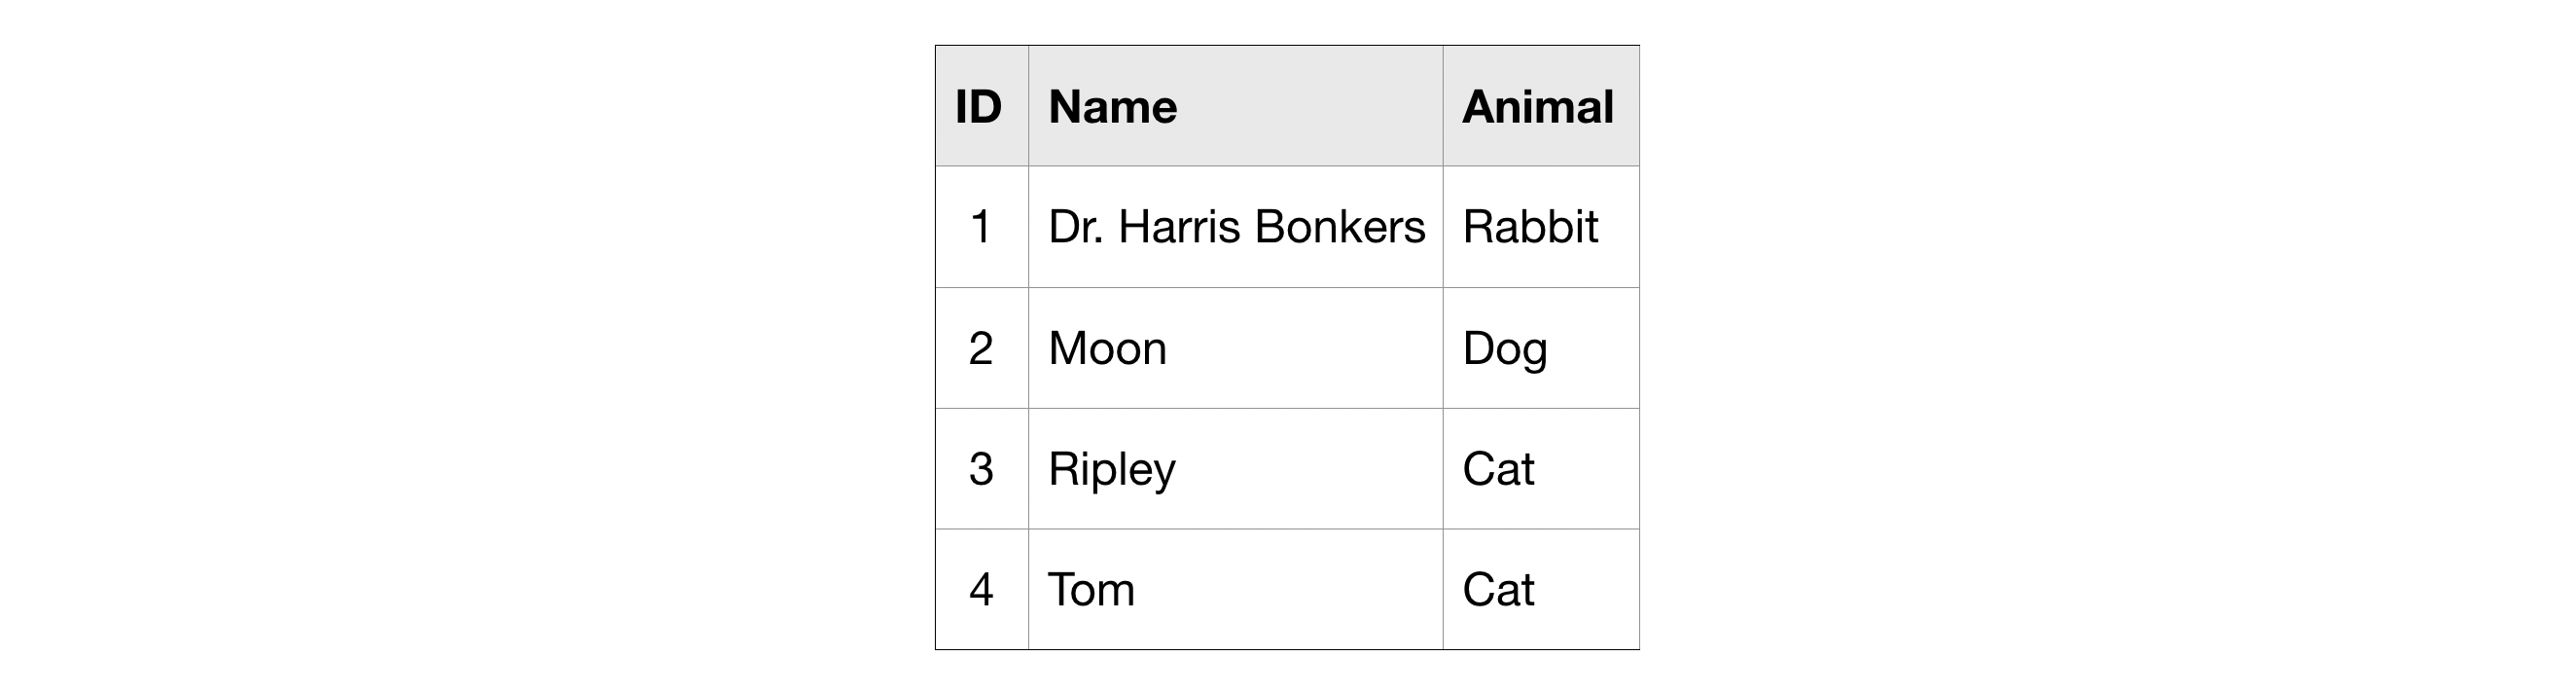

## SELECT ... FROM
Esta es la *query* más básica, **seleccionará una columna de la tabla**. Deberemos indicar el nombre de la columna deseada luego de *SELECT* y la tabla correspondiente luego de *FROM*.
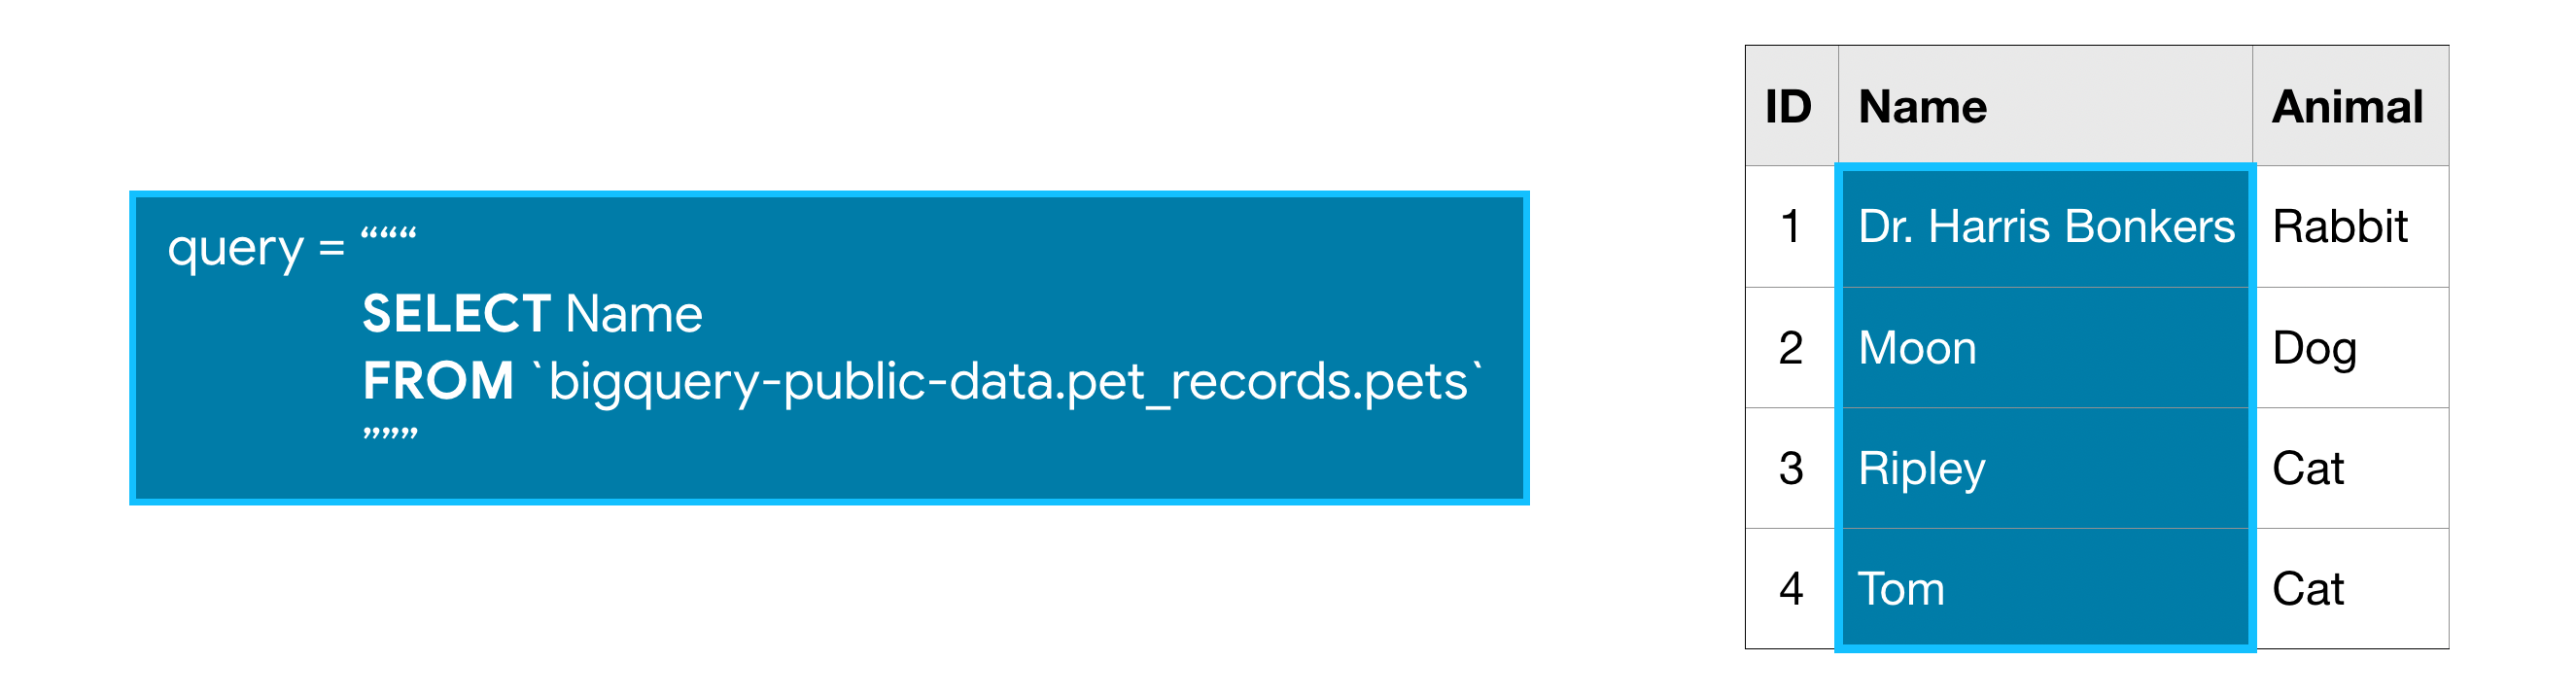

**IMPORTANTE:** el **argumento del *FROM*** no va entre comillas simples ni dobles, sino con **backticks**, y sigue una nomenclatura del tipo atributos de un objeto *proyecto.dataset.tabla*.

## WHERE
Este comando nos permite seleccionar **sólo las filas que cumplan con cierta condición**. Continuando el ejemplo, seleccionaremos de la tabla anterior, solo aquellas filas que en la columna *Animal* contengan *'cat'*.
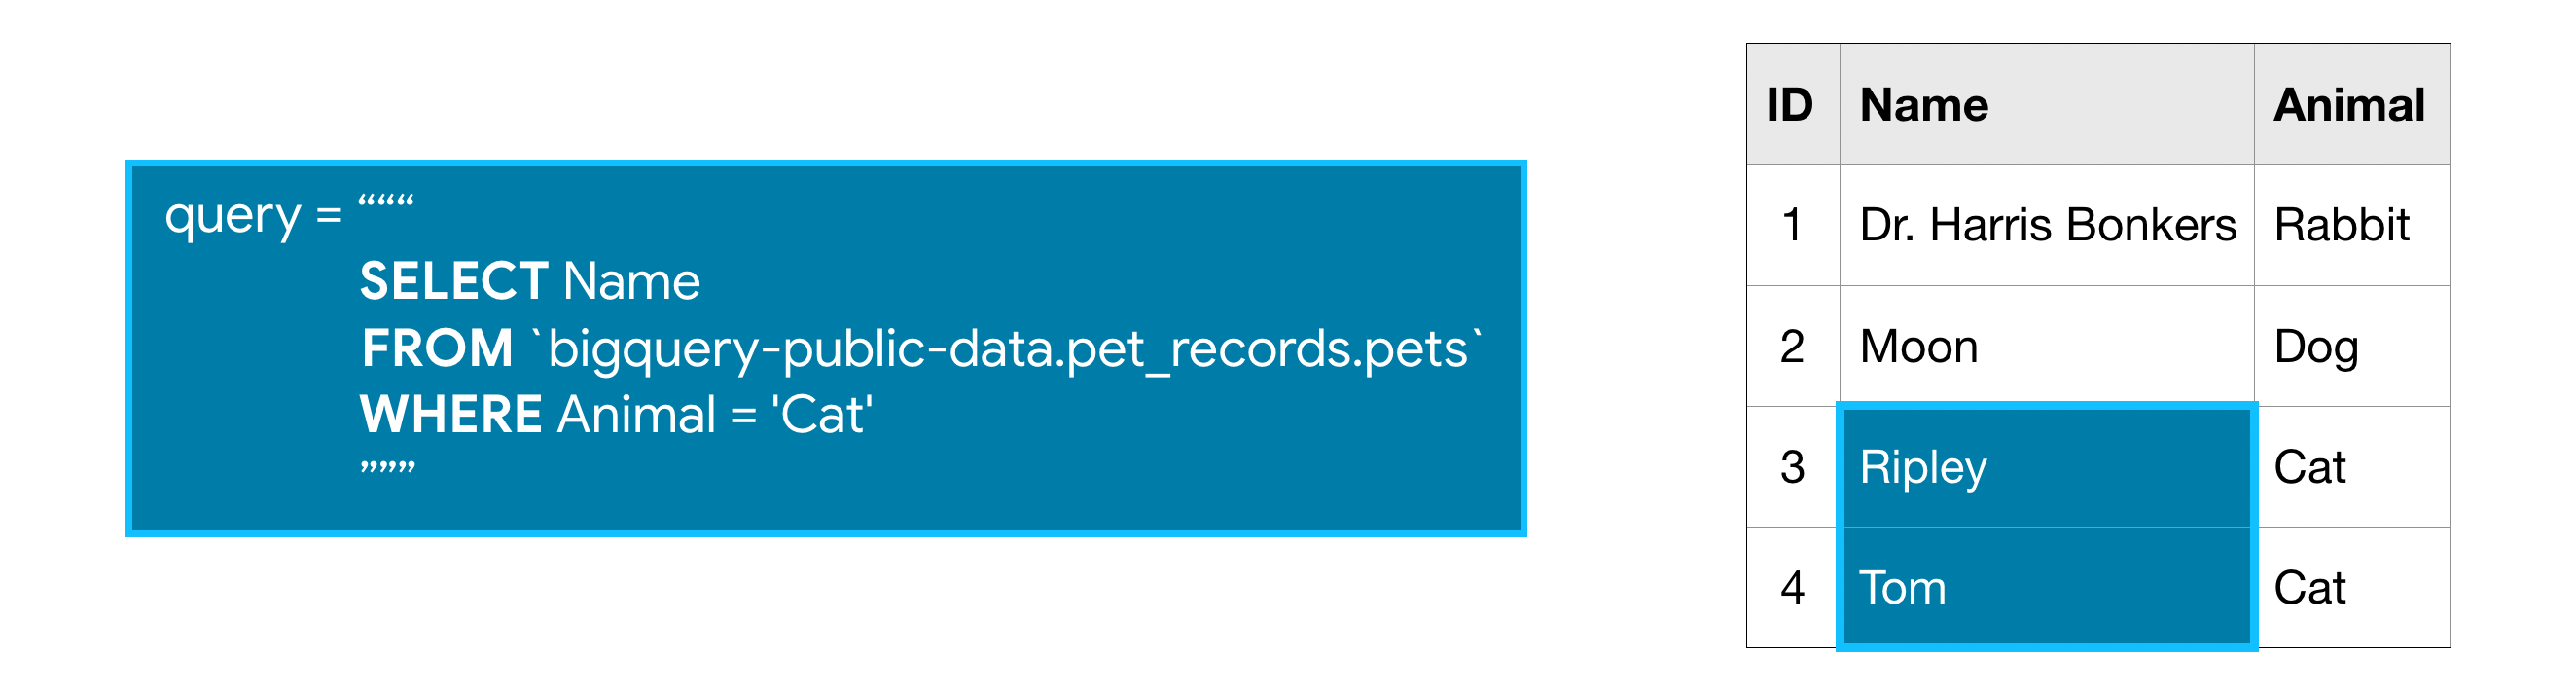

## Enviar la consulta
Una vez construida nuestra consulta *sql*, para enviarla al dataset y obtener efectivamente los datos deseados, utilizaremos el método **client.query()**. Este método posee argumentos para opciones más avanzadas, pero por lo pronto, comenzaremos con los parámetros por defecto.
- **query_job = client.query(query)**
- **result = query_job.to_dataframe()**, convirtiendo el resultado a un Dataframe para mejor uso (con todos los métodos que ya conocemos).

## Múltiples columnas
Así como realizamos una consulta que nos devuelve los valores de una columna, podremos indicarle que sean múltiples de ellas, simplemente **separando por coma las columnas deseadas.** Incluso, podemos **seleccionar todas las columnas mediante un *.**

## Limitación tamaño de Query
En Kaggle cada usuario dispone de una cuota de 5TB mensual de escaneo de Base de datos, teniendo en cuenta esto y que existen datasets de, por ejemplo, 3TB, podría superarse fácilmente este límite si no se trabaja con cuidado. 

Para evitar este conflicto, existen operaciones que permiten limitar la ejecución de una *query* si la misma supera un determinado tamaño de lectura.
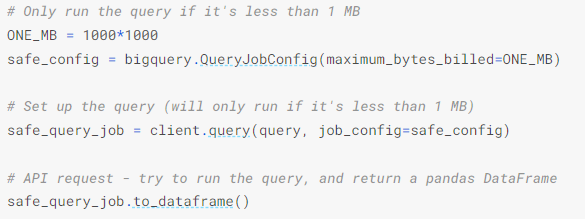


Hay otro método que permite estimar el tamaño de la *query* sin procesarla.
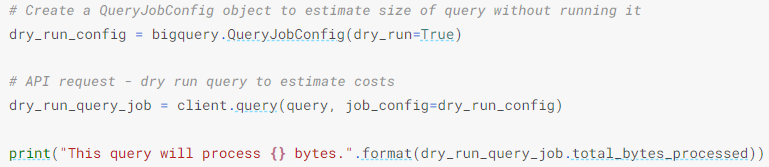

## Práctica
Trabajaremos con el **dataset openaq** que contiene información sobre la polución en distintas ciudades del mundo.
1. **Unidades de medida:** Realizar una consulta que muestre qué países han reportado la polución en unidades de "ppm".

In [2]:
from google.cloud import bigquery

client = bigquery.Client()

# fetcheo el dataset y veo las tablas que tiene
dataset_ref = client.dataset('openaq', project='bigquery-public-data')
dataset = client.get_dataset(dataset_ref)

tables = list(client.list_tables(dataset))
for table in tables:
    print(table.table_id)

global_air_quality


Observamos que posee una única **tabla global_air_quality** que es la que utilizaremos durante el ejercicio. Por tanto, la inspeccionamos para ver qué datos tiene.

In [3]:
# fetcheo la tabla global_air_quality
aq_table_ref = dataset_ref.table('global_air_quality')
air_quality_table = client.get_table(aq_table_ref)

# inspecciono tabla y sus datis
client.list_rows(air_quality_table, max_results=5).to_dataframe()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
0,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,co,910.00,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
1,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,no2,131.87,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
2,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,o3,15.57,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
3,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,pm25,45.62,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
4,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,so2,4.49,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25


Ahora si, habiendo visto todos los datos que la tabla presenta, realizamos la consulta en cuestión.

In [11]:
countries_ppm_query = '''
SELECT country
FROM `bigquery-public-data.openaq.global_air_quality`
WHERE unit='ppm'
'''

# antes de hacer la query, siempre protejo por tamaño de consulta
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(countries_ppm_query, job_config=safe_config)

# resultado (pasado a Dataframe, para manipulacion sencilla)
countries_ppm = query_job.to_dataframe()
countries_ppm

,country
0,US
1,US
2,US
3,US
4,US
...,...
3545,TW
3546,TW
3547,TW
3548,TW


In [13]:
countries_ppm.country.unique()

array(['US', 'CL', 'AU', 'BM', 'MX', 'AE', 'NP', 'CH', 'UZ', 'CA', 'GB',
       'IL', 'TW', 'CO', 'TH', 'BR', 'PE', 'AR', 'ZA', 'BH', 'CW'],
      dtype=object)

## Operador DISTINCT
Este nos permite, al ejecutar un *SELECT* que sólo se tomen valores distintos, es decir, que no acumula filas que repitan un valor en la columna seleccionada. 

En el ejemplo visto, sería que no repita filas del mismo país, esto evita tener que aplicar luego el *unique()*.

In [15]:
countries_ppm_query = '''
SELECT DISTINCT country
FROM `bigquery-public-data.openaq.global_air_quality`
WHERE unit='ppm'
'''

# antes de hacer la query, siempre protejo por tamaño de consulta
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(countries_ppm_query, job_config=safe_config)

# resultado (pasado a Dataframe, para manipulacion sencilla)
countries_ppm = query_job.to_dataframe()
countries_ppm

,country
0,US
1,CL
2,AU
3,BM
4,MX
5,AE
6,NP
7,CH
8,UZ
9,CA


2. Realizar una consulta que nos permita concer los datos de las entradas que presentaron un nivel 0 de polución.

In [17]:
zero_pollution_query = '''
SELECT *
FROM `bigquery-public-data.openaq.global_air_quality`
WHERE value=0
'''

zp_query_job = client.query(zero_pollution_query, job_config=safe_config)
zero_pollution = zp_query_job.to_dataframe()

zero_pollution.head()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
0,Victoria Memorial - WBSPCB,Kolkata,IN,pm25,0.0,2017-10-16 20:45:00+00:00,µg/m³,CPCB,22.572645,88.363890,0.25
1,"Rabindra Bharati University, Kolkata - WBSPCB",Kolkata,IN,so2,0.0,2017-10-28 14:30:00+00:00,µg/m³,CPCB,22.627874,88.380400,0.25
2,Zamość ul. Hrubieszowska 69A,Zamość,PL,no2,0.0,2020-05-19 05:00:00+00:00,µg/m³,GIOS,50.716630,23.290247,NaN
3,"Końskie, MOBILNA",Końskie,PL,pm10,0.0,2018-12-21 13:00:00+00:00,µg/m³,GIOS,51.189526,20.408892,NaN
4,"Końskie, MOBILNA",Końskie,PL,pm25,0.0,2018-12-21 13:00:00+00:00,µg/m³,GIOS,51.189526,20.408892,NaN
